In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# # PyTorch Lightning
import pytorch_lightning as pl
# from pytorch_lightning import Trainer
# from pytorch_lightning.loggers import WandbLogger
# # from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import netCDF4

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 512 if AVAIL_GPUS else 64

In [3]:
pl.seed_everything(125)

Global seed set to 125


125

## Load Data

In [8]:
sho = netCDF4.Dataset('../data/sho.nc').variables # HDF5 
t_sho = np.array(sho['t'][:], dtype=np.float32)[::100]
s_sho = np.array(sho['s'][:], dtype=np.float32)[::100]
v_sho = np.array(sho['v'][:], dtype=np.float32)[::100]

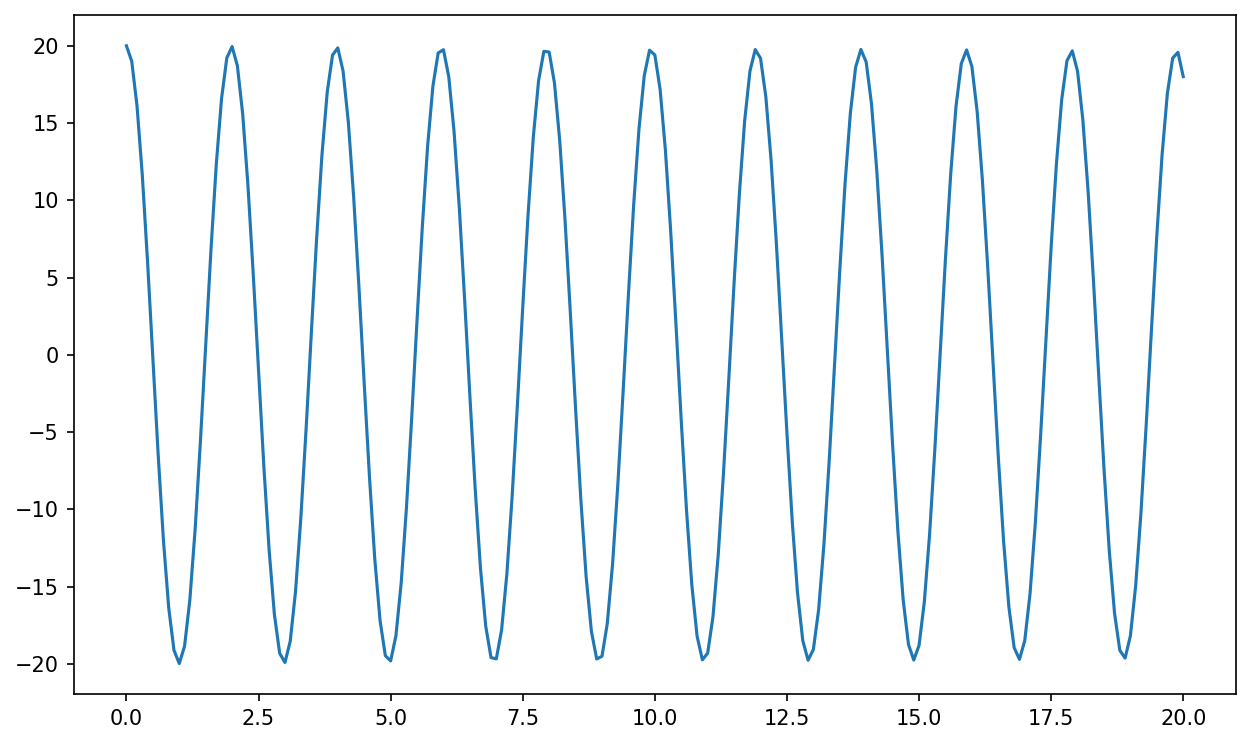

In [9]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, s_sho)
plt.show()

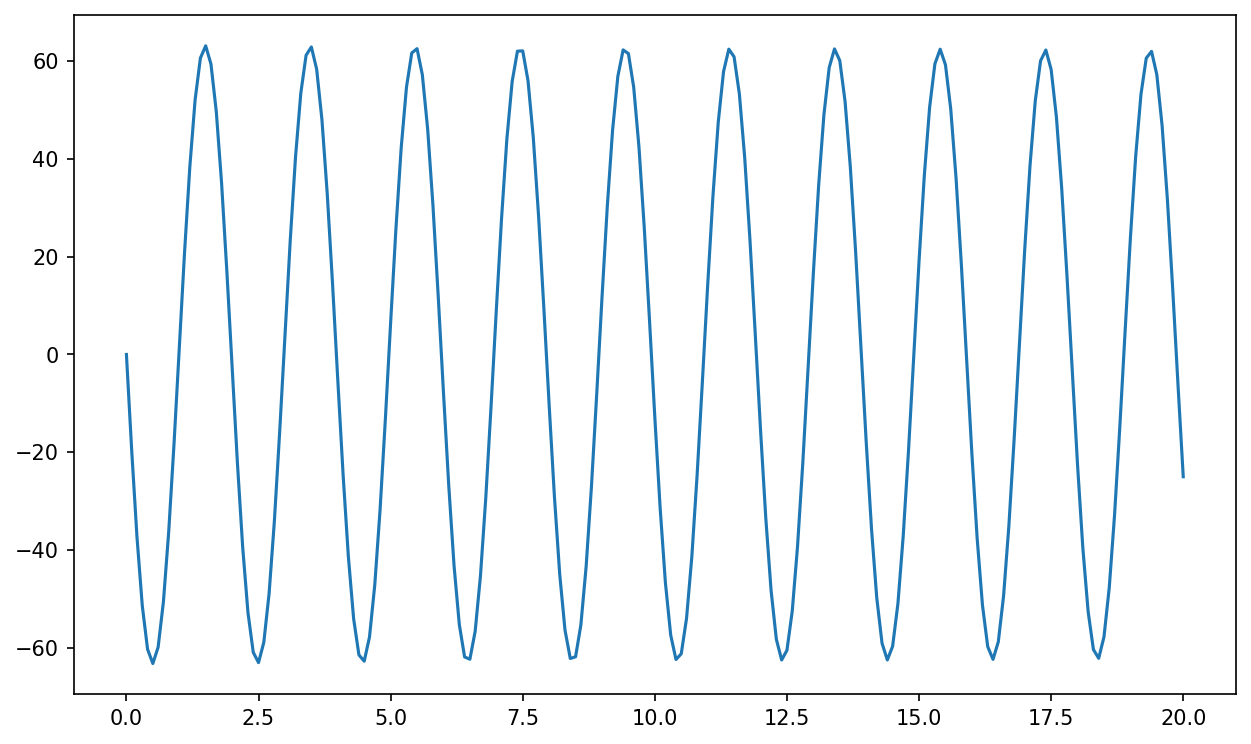

In [10]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, v_sho)
plt.show()

In [11]:
# X_total = np.column_stack([s_sho, v_sho])
X_total = s_sho.reshape(-1, 1)
sc = MinMaxScaler()
X_normalized = sc.fit_transform(X_total)

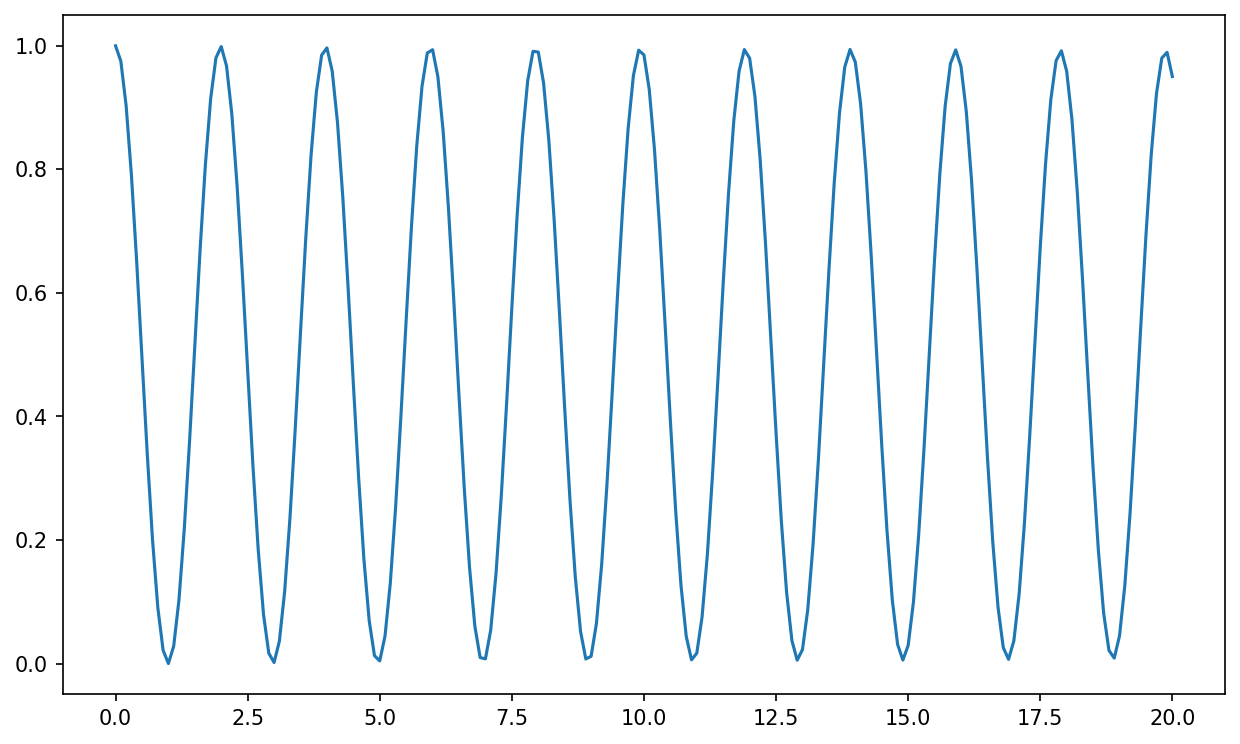

In [12]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t_sho, X_normalized[:,0])
plt.show()

In [13]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [14]:
X, y = sliding_window(X_normalized, 10)

In [15]:
X[0:2]

array([[[1.        ],
        [0.975155  ],
        [0.9031712 ],
        [0.7911943 ],
        [0.650335  ],
        [0.49456578],
        [0.33933538],
        [0.20003664],
        [0.09047994],
        [0.02152404]],

       [[0.975155  ],
        [0.9031712 ],
        [0.7911943 ],
        [0.650335  ],
        [0.49456578],
        [0.33933538],
        [0.20003664],
        [0.09047994],
        [0.02152404],
        [0.        ]]], dtype=float32)

In [16]:
y

array([[0.        ],
       [0.02803427],
       [0.10283867],
       [0.21698764],
       [0.35915557],
       [0.51524013],
       [0.6697615 ],
       [0.80739737],
       [0.9145024 ],
       [0.980461  ],
       [0.9987395 ],
       [0.96753323],
       [0.8899451 ],
       [0.7736764 ],
       [0.630263  ],
       [0.47393042],
       [0.32018307],
       [0.18426627],
       [0.07965475],
       [0.01671669],
       [0.00168616],
       [0.03604567],
       [0.11637983],
       [0.2347149 ],
       [0.3793103 ],
       [0.53582346],
       [0.6887322 ],
       [0.82287455],
       [0.924952  ],
       [0.98484755],
       [0.99662906],
       [0.95913625],
       [0.8760952 ],
       [0.7557478 ],
       [0.6100343 ],
       [0.45340788],
       [0.3014018 ],
       [0.16908833],
       [0.06958458],
       [0.01275203],
       [0.0042192 ],
       [0.04482406],
       [0.13053206],
       [0.25283676],
       [0.39960414],
       [0.5562765 ],
       [0.70731634],
       [0.837

In [17]:
y.shape

(190, 1)

In [18]:
N = X.shape[0]
N_train = 100
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:150]
y_test = y[N_train:150]

In [19]:
class NewtonData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
ds_train = NewtonData(X_train, y_train)
ds_val = NewtonData(X_test, y_test)

In [21]:
len(ds_train)

100

In [22]:
len(ds_val)

50

In [23]:
ds_train[0][0].shape

(10, 1)

In [24]:
dl_train = DataLoader(ds_train, batch_size=10, shuffle=True)

In [25]:
ds_train[0]

(array([[1.        ],
        [0.975155  ],
        [0.9031712 ],
        [0.7911943 ],
        [0.650335  ],
        [0.49456578],
        [0.33933538],
        [0.20003664],
        [0.09047994],
        [0.02152404]], dtype=float32),
 array([0.], dtype=float32))

In [26]:
class SingleRNN(nn.Module):

    def __init__(self, input_size, hidden_size, dropout=0, bidirectional=False):
        super(SingleRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_direction = int(bidirectional) + 1
        self.rnn = nn.LSTM(input_size, hidden_size, 1, dropout=dropout, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # input shape: batch, seq, dim
        rnn_output, _ = self.rnn(x)
        output = self.fc(rnn_output)
        
        return output[:,-1,:]

In [33]:
model = SingleRNN(input_size=1, hidden_size=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
model.eval()
dl_iter = iter(dl_train)
x_one, y_one = next(dl_iter)

In [35]:
x_one.shape

torch.Size([10, 10, 1])

In [36]:
y_one.shape

torch.Size([10, 1])

In [37]:
model(x_one).shape

torch.Size([10, 1])

In [38]:
epochs = 1000
model.train()
for epoch in range(epochs+1):
    for x, y in dl_train:
        y_hat = model(x)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.87605268
epoch:  100 loss:0.02537846
epoch:  200 loss:0.00019194
epoch:  300 loss:0.00001336
epoch:  400 loss:0.00000928
epoch:  500 loss:0.00000718
epoch:  600 loss:0.00000420
epoch:  700 loss:0.00000346
epoch:  800 loss:0.00000247
epoch:  900 loss:0.00000256
epoch: 1000 loss:0.00000164


In [39]:
model.eval()

SingleRNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [40]:
X, y = sliding_window(X_normalized, 10)

In [41]:
total_data = NewtonData(X, y)

In [42]:
dl = DataLoader(total_data, batch_size=len(total_data))
dl_iter = iter(dl)
X, y = next(dl_iter)

In [43]:
y.shape

torch.Size([190, 1])

In [53]:
t = t_sho[10:-1]
t.shape

(190,)

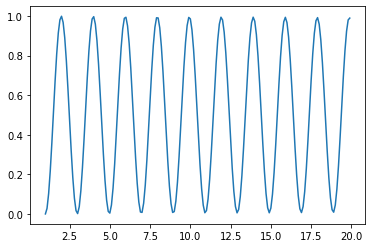

In [54]:
plt.plot(t, y.detach().numpy())

In [55]:
y_pred = model(X)

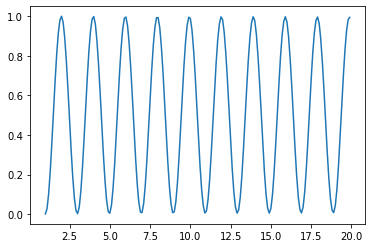

In [56]:
plt.plot(t, y_pred.detach().numpy())

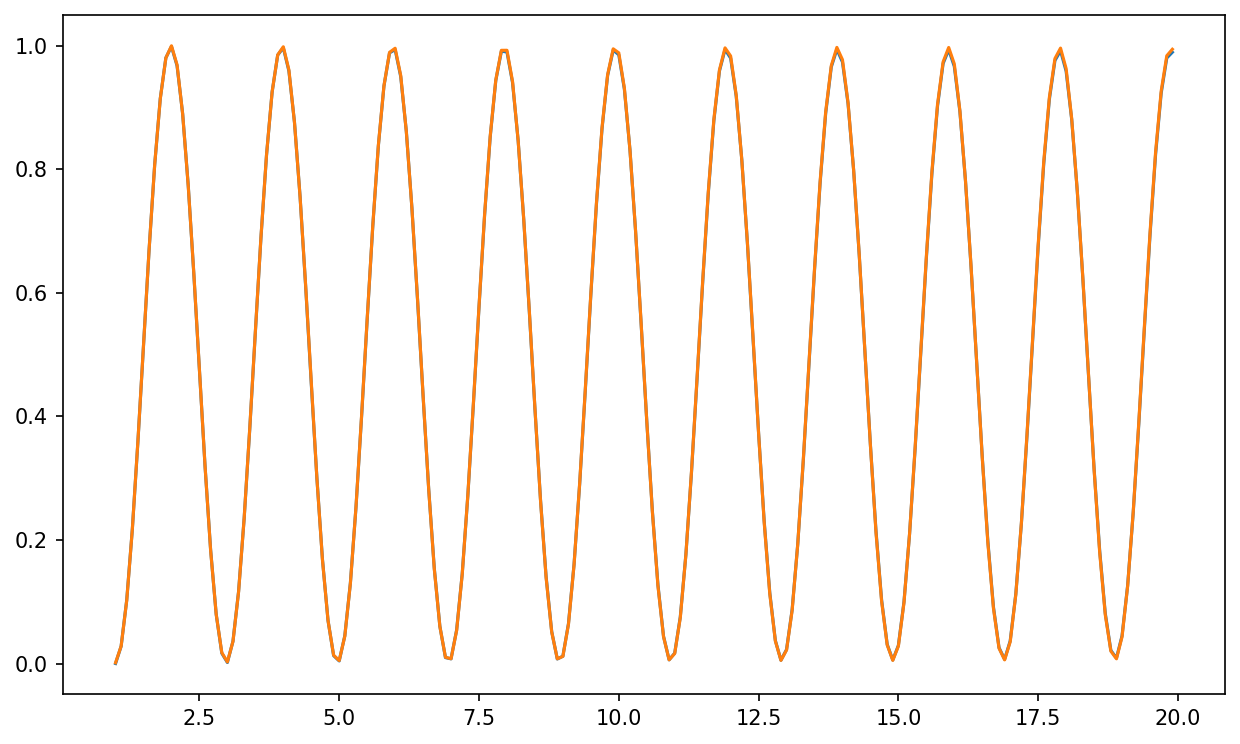

In [57]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(t, y.cpu().numpy())
plt.plot(t, y_pred.detach().numpy())
plt.show()

In [64]:
N_extrap = 300
X_new = X[0]
X_new.shape

torch.Size([10, 1])

In [65]:
X_new.view(1,-1,1)

tensor([[[1.0000],
         [0.9752],
         [0.9032],
         [0.7912],
         [0.6503],
         [0.4946],
         [0.3393],
         [0.2000],
         [0.0905],
         [0.0215]]])

In [66]:
y_ex = []
t_ex = []
dt = 1e-1
for i in range(N_extrap):
    y_new = model(X_new.view(1, -1, 1))
    X_new = torch.concat([X_new[1:], y_new])
    t_ex.append(t[0] + i * dt)
    y_ex.append(y_new.view(-1).detach().numpy())

In [67]:
# t_total = np.concatenate([t, t_ex])
t_total = t_ex
# y_pred_total = np.concatenate([y_pred.detach().numpy(), y_ex])
y_pred_total = y_ex

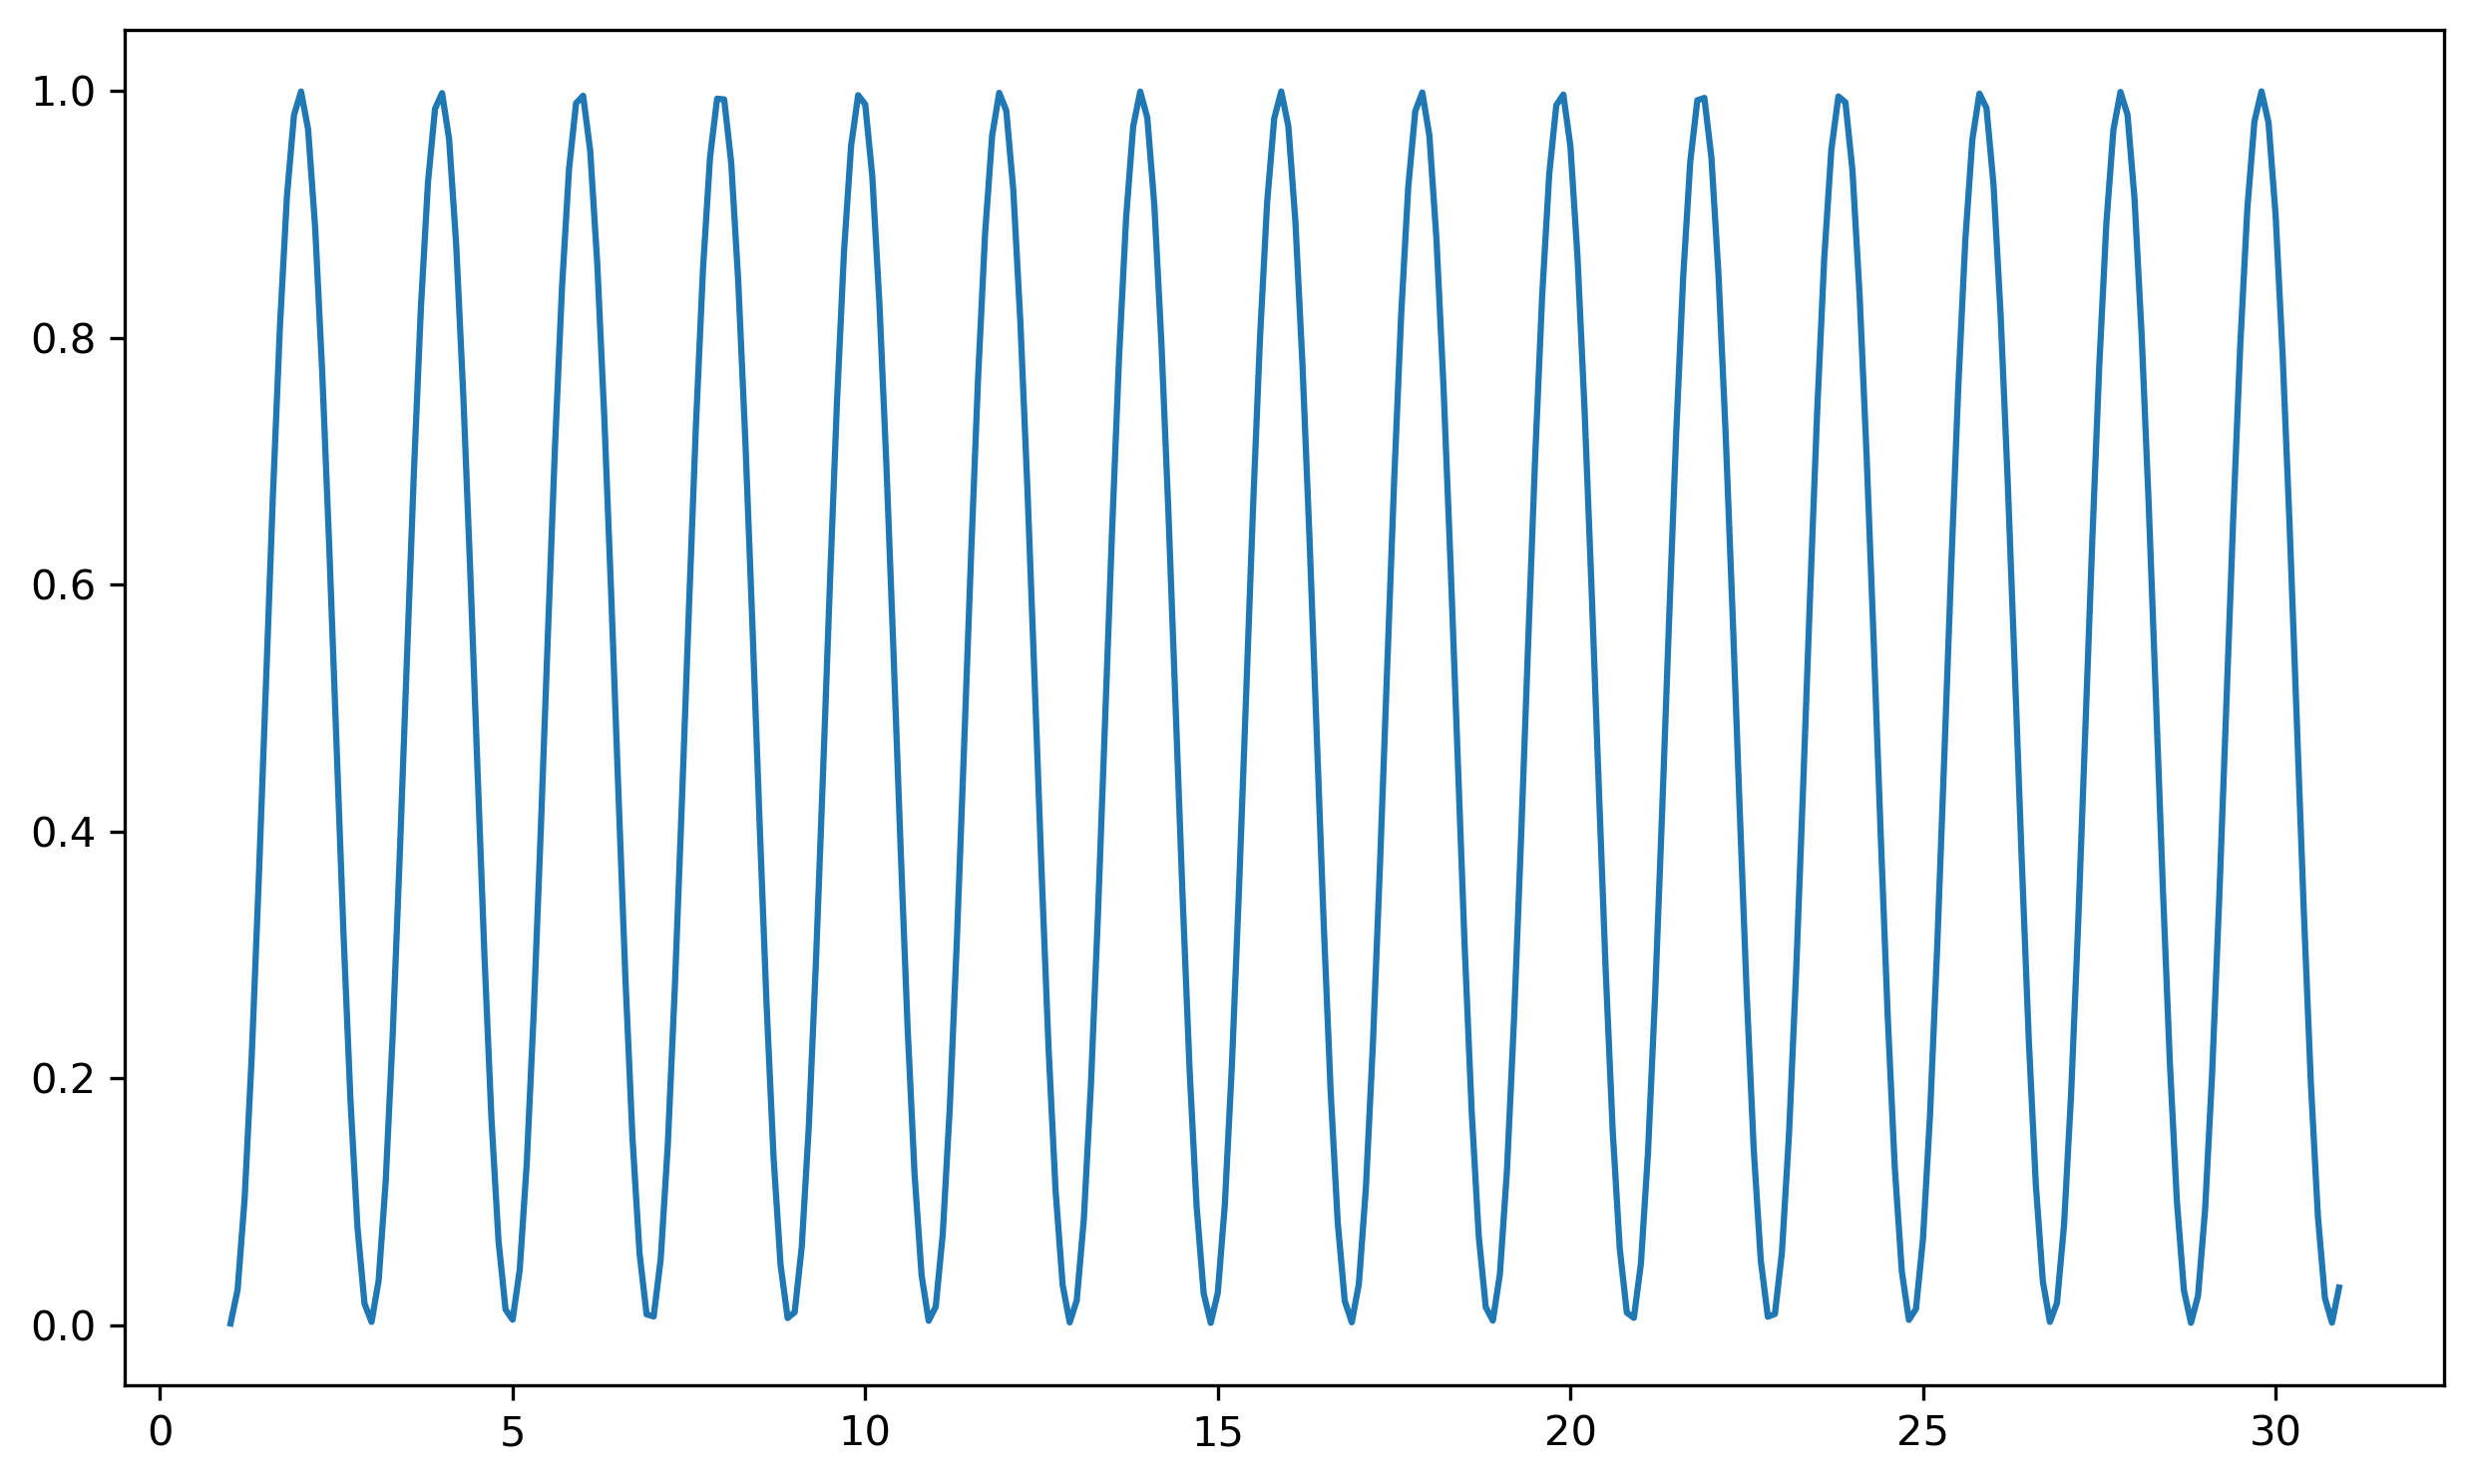

In [68]:
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(t_total, y_pred_total)
# plt.xlim(left=19.99,right=20.09)
# plt.axvline(t[-1], linestyle='--', color='r')